# **Prep**

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch, torchvision, math, matplotlib, random
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import *
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import seaborn as sns

from tqdm import tqdm

print("USING GPU" if torch.cuda.is_available() else "USING CPU")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

USING GPU


In [2]:
def load_mnist():
  transforms        = torchvision.transforms.ToTensor()
  mnist_trainset    = datasets.MNIST(root='./data', train=True,  download=True, transform=transforms)
  mnist_testset     = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

  return mnist_trainset, mnist_testset

In [3]:
def load_fashion_mnist():
  transforms        = torchvision.transforms.ToTensor()
  fashion_trainset    = datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transforms)
  fashion_testset     = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms)

  return fashion_trainset, fashion_testset

In [4]:
def load_cifar10():
  transforms        = torchvision.transforms.ToTensor()
  cifar_trainset    = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transforms)
  cifar_testset     = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

  return cifar_trainset, cifar_testset

## **Functions**

In [5]:
# MODIFIER POUR PERMETTRE IMAGE COULEUR OU NB
def reconstruct_imgs(model,ds,n, conditional=False):
    w = round(math.sqrt(n))
    h = math.ceil(n/w)
    fig, axs = plt.subplots(h,w*2,figsize=(w*2,h))
    nb_examples = 0

    for i in range(h):
      for j in range(w):
        idx = random.randint(0,len(ds))
        if nb_examples < n:
          print(f"{nb_examples}/{n}")
          nb_examples += 1
          x   = ds[idx][0].to(device)

          if conditional:
            y = ds[idx][1]
            y = (y[None, :]).to(device)
            rec = model(x.reshape(1, x.size(0), x.size(1), x.size(2)), y)[0]
          else:
            rec = model(x.reshape(1,x.size(0),x.size(1),x.size(2)))[0]

          if x.size(0) == 1 :
            x = torch.cat((x,x,x))
            rec = torch.cat((rec,rec,rec))

          axs[i][j*2].imshow(x.permute(1, 2, 0).cpu().detach())
          axs[i][j*2+1].imshow(rec.permute(1, 2, 0).cpu().detach())
        axs[i][j*2].axis('off')
        axs[i][j*2+1].axis('off')
    clear_output()

In [6]:
def generate_imgs(model,n,nb_features, conditional=False):
    w = round(math.sqrt(n))
    h = math.ceil(n/w)
    fig, axs = plt.subplots(h,w,figsize=(w,h))
    nb_examples = 0

    for i in range(h):
      for j in range(w):
        if nb_examples < n:
          print(f"{nb_examples}/{n}")
          nb_examples += 1          
          z = torch.distributions.Normal(torch.zeros(1, nb_features), torch.ones(1, nb_features)).sample().to(device)

          if conditional:
            label = nb_examples % 10
            y = torch.tensor(((0, 0, 0, 0, 0, 0, 0, 0, 0, 0),))
            y[0][label] = 1
            y = y.to(device)
            new_img = model.decoder(z, y)[0]
          else:
            new_img = model.decoder(z)[0]

          if new_img.size(0) == 1 :
            new_img = torch.cat((new_img,new_img,new_img))

          axs[i][j].imshow(new_img.permute(1, 2, 0).cpu().detach())
          if conditional:
            axs[i][j].set_title(str(label))
        axs[i][j].axis('off')
    clear_output()

In [7]:
def generate_plan_imgs(model,w,h,nb_features,x_lim,y_lim,V):
    n = w*h
    fig, axs = plt.subplots(h,w,figsize=(w,h))
    nb_examples = 0

    z1_range = torch.arange(x_lim[0],x_lim[1], (x_lim[1]-x_lim[0])/w).to(device)
    z2_range = torch.arange(y_lim[0],y_lim[1], (y_lim[1]-y_lim[0])/h).to(device)
    z1, z2 = torch.meshgrid(z1_range, z2_range)
    z1=z1.reshape(z1.shape[1]*z1.shape[0],1).to(device)
    z2=z2.reshape(z2.shape[1]*z2.shape[0],1).to(device)
    z0=torch.zeros_like(z1).to(device)
    z=torch.cat([z1,z2],axis=1).to(device)
    if nb_features>2:
      for k in range(nb_features-2):
        z=torch.cat([z,z0],axis = 1).to(device)
    z_original = torch.matmul(z,torch.linalg.inv(V))


    for i in range(h):
        for j in range(w):

            z=z_original[nb_examples].reshape(1,nb_features)
            #z = torch.distributions.Normal(torch.zeros(1,nb_features), torch.ones(1,nb_features)).sample().to(device)
            new_img = model.decoder(z)[0]

            if new_img.size(0) == 1 :
                new_img = torch.cat((new_img,new_img,new_img))

            axs[i][j].imshow(new_img.permute(1, 2, 0).cpu().detach())

            axs[i][j].axis('off')
            print(z)
            nb_examples += 1
            clear_output()

## **Training loops (AE/VAE)**

In [8]:
def fit_ae(model_ae, optimizer, train_dl, epochs, window_size):
  avg_loss,i = 0,0
  history    = []

  for n in range(epochs):
    clear_output()
    print(f"--- EPOCH {n+1}/{epochs}")
    for (batch_x, batch_y) in train_dl:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)   # Put the tensors on GPU
      optimizer.zero_grad()                                       # Reset the computed gradients 
      out  = model_ae(batch_x)                                    # Compute model's logits (raw outputs before softmax)
      loss = nn.BCELoss(size_average=False)(out,batch_x) / batch_x.size(0)                             # Compute loss
      loss.backward()                                             # Compute gradients by backpropagating the loss
      optimizer.step()

      # Moving average of the loss
      avg_loss += loss.item()
      i        += 1
      if i==window_size:
        avg_loss /= window_size
        history.append(avg_loss)
        print(avg_loss)
        avg_loss,i = 0,0

    clear_output()
    plt.plot(range(len(history)),history,label="Training loss")
    plt.show()

In [9]:
def fit_vae(model_vae, optimizer, train_dl, epochs, window_size, conditional=False):
  avg_loss,i = 0,0
  history    = []

  c = .1 if conditional else 1

  for n in range(epochs):
    clear_output()
    print(f"--- EPOCH {n+1}/{epochs}")
    for (batch_x, batch_y) in train_dl:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)   # Put the tensors on GPU
      optimizer.zero_grad()                                       # Reset the computed gradients 
      if conditional:
        out = model_vae(batch_x, batch_y)
      else:
        out  = model_vae(batch_x)                                    # Compute model's logits (raw outputs before softmax)
      rec_loss = nn.BCELoss(reduction="sum")(out,batch_x)
      reg_loss = model_vae.encoder.kl
      loss = rec_loss + c * reg_loss          # Compute loss
      loss.backward()                                             # Compute gradients by backpropagating the loss
      optimizer.step()

      # Moving average of the loss
      avg_loss += loss.item() / batch_x.size(0)
      i        += 1
      if i==window_size:
        avg_loss /= window_size
        history.append(avg_loss)
        print(avg_loss, rec_loss.item(), reg_loss.item())
        avg_loss,i = 0,0

    clear_output()
    plt.plot(range(len(history)),history,label="Training loss")
    plt.show()

# **AE for MNIST**

## **Architecture**

In [ ]:
########## ENCODER (nb_features = dimensionality of the latent space)
class Encoder(nn.Module):
    def __init__(self, nb_features):  
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.bn    = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)

        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, nb_features)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nb_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(nb_features,128)
        self.linear2 = nn.Linear(128,3*3*32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.bn1      = nn.BatchNorm2d(16)
        self.bn2      = nn.BatchNorm2d(8)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = nn.Sigmoid()(self.deconv3(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, nb_features):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(nb_features)
        self.decoder = Decoder(nb_features)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## **Training**

In [ ]:
train_ds, test_ds = load_mnist()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

z_dim = 4

ae_mnist = Autoencoder(z_dim).to(device)
optimizer  = optim.Adam(ae_mnist.parameters(), lr=0.001, weight_decay=0.00001)
fit_ae(ae_mnist, optimizer, train_dl, epochs=10, window_size=10)

## **Latent space**

In [ ]:
z_train = torch.empty([0,z_dim]).to(device)
label_train = torch.empty([0]).to(device)
for (batch_x, batch_y) in train_dl:
  batch_x, batch_y = batch_x.to(device), batch_y.to(device)
  out  = ae_mnist.encoder(batch_x)
  z_train = torch.cat([z_train,out])
  label_train = torch.cat([label_train,batch_y])

explained variance: tensor(0.7457, device='cuda:0', grad_fn=<DivBackward0>)


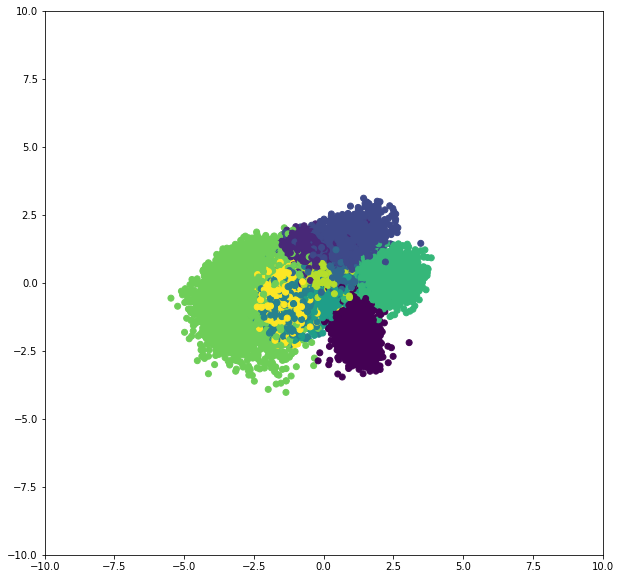

In [ ]:
U, S, V = torch.pca_lowrank(z_train)
U = U.to(device)
S = S.to(device)
V = V.to(device)
z_train_2dim = torch.matmul(z_train,V[:,:2]).to(device)

print('explained variance: '+str(torch.sum(S[:2]**2/(60000))/torch.sum(S**2/(60000))))

plt.figure(figsize=(10,10))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(z_train_2dim[:,0].cpu().detach().numpy(),z_train_2dim[:,1].cpu().detach().numpy(),c=label_train.cpu())

## **Reconstruction and Generation of the images**

In [ ]:
reconstruct_imgs(ae_mnist,test_ds,25)

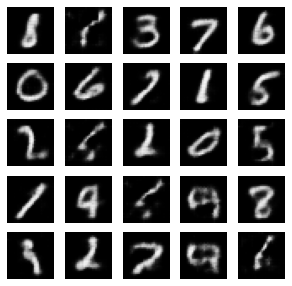

In [ ]:
generate_imgs(ae_mnist,25,z_dim)

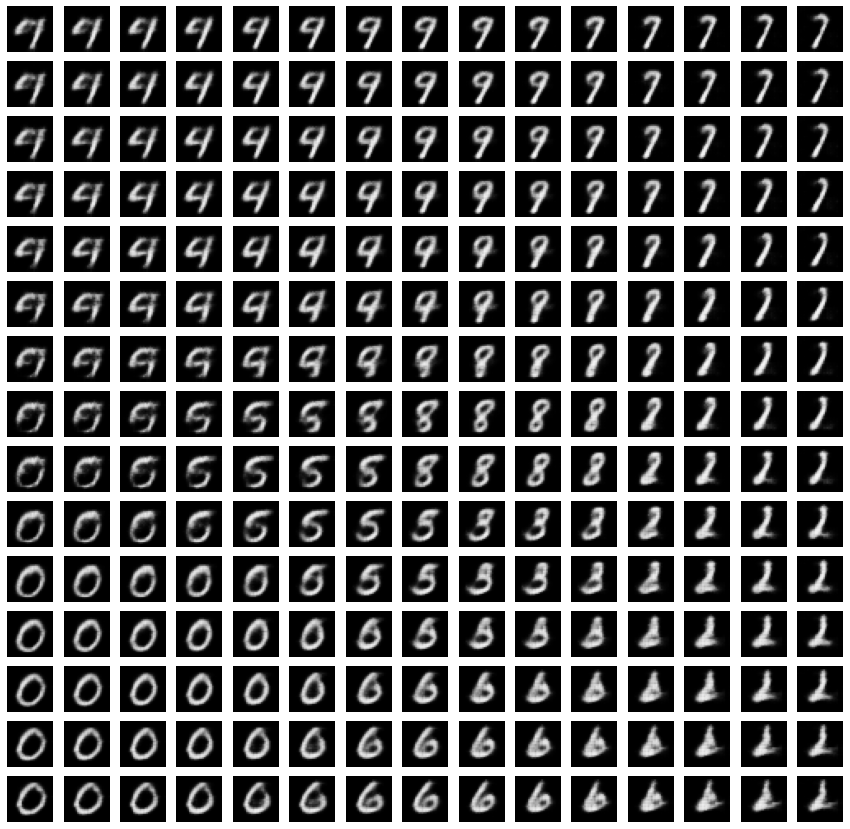

In [ ]:
generate_plan_imgs(ae_mnist,15,15,z_dim,[-2,2],[-2,2],V)

# **AE for fashion-MNIST**

## **Architecture**

In [ ]:
########## ENCODER (nb_features = dimensionality of the latent space)
class Encoder(nn.Module):
    def __init__(self, nb_features):  
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.bn    = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)

        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, nb_features)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nb_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(nb_features,128)
        self.linear2 = nn.Linear(128,3*3*32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.bn1      = nn.BatchNorm2d(16)
        self.bn2      = nn.BatchNorm2d(8)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = nn.Sigmoid()(self.deconv3(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, nb_features):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(nb_features)
        self.decoder = Decoder(nb_features)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## **Train**

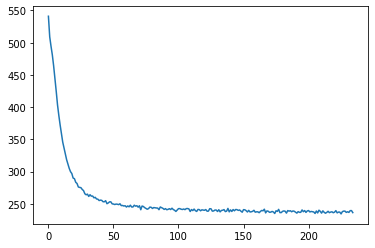

In [ ]:
train_ds, test_ds = load_fashion_mnist()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

z_dim = 4
ae_fashion = Autoencoder(z_dim).to(device)
optimizer  = optim.Adam(ae_fashion.parameters(), lr=0.001, weight_decay=0.00001)
fit_ae(ae_fashion, optimizer, train_dl, epochs=10, window_size=10)

## **Latent Space**

In [ ]:
z_train = torch.empty([0,z_dim]).to(device)
label_train = torch.empty([0]).to(device)
for (batch_x, batch_y) in train_dl:
  batch_x, batch_y = batch_x.to(device), batch_y.to(device)
  out  = ae_fashion.encoder(batch_x)
  z_train = torch.cat([z_train,out])
  label_train = torch.cat([label_train,batch_y])

explained variance: tensor(0.7189, device='cuda:0', grad_fn=<DivBackward0>)


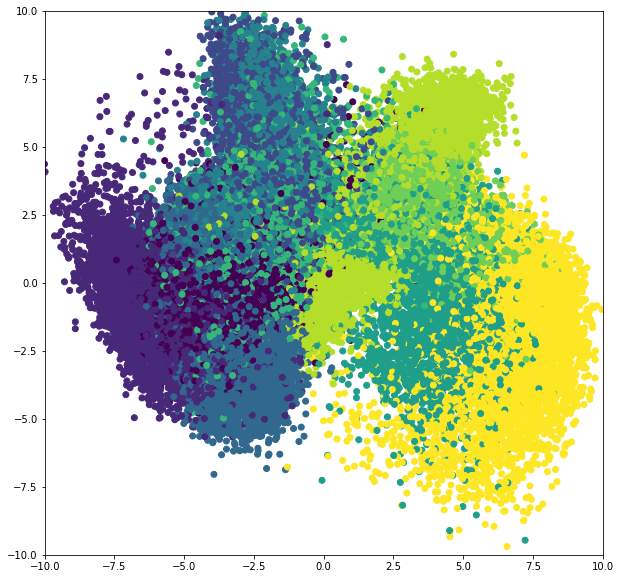

In [ ]:
U, S, V = torch.pca_lowrank(z_train)
U = U.to(device)
S = S.to(device)
V = V.to(device)
z_train_2dim = torch.matmul(z_train,V[:,:2]).to(device)

print('explained variance: '+str(torch.sum(S[:2]**2/(60000))/torch.sum(S**2/(60000))))

plt.figure(figsize=(10,10))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(z_train_2dim[:,0].cpu().detach().numpy(),z_train_2dim[:,1].cpu().detach().numpy(),c=label_train.cpu())

## **Reconstruction and Generation of the images**

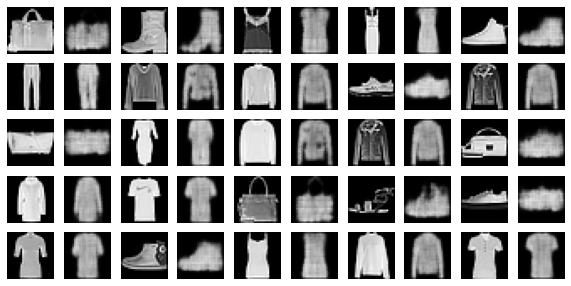

In [ ]:
reconstruct_imgs(ae_fashion,test_ds,25)

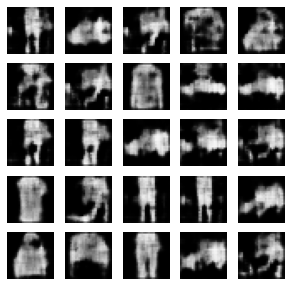

In [ ]:
generate_imgs(ae_fashion,25,z_dim)

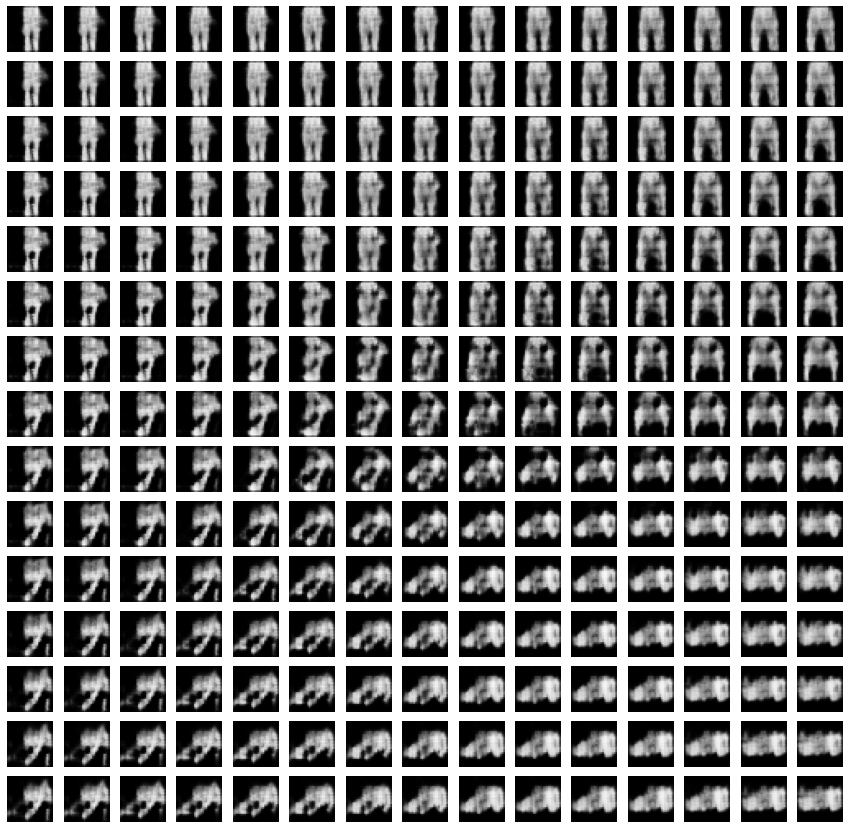

In [ ]:
generate_plan_imgs(ae_fashion,15,15,z_dim,[-2,2],[-2,2],V)

# **AE for CIFAR-10**

### **Architecture**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, nb_features):  
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.bn1    = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2    = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.linear = nn.Linear(64*4*4, nb_features)


    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = (self.linear(x))
        
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nb_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(nb_features,64*4*4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)

        self.bn1      = nn.BatchNorm2d(32)
        self.bn2      = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = nn.Unflatten(dim=1, unflattened_size=(64, 4, 4))(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = nn.Sigmoid()(self.deconv3(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, nb_features):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(nb_features)
        self.decoder = Decoder(nb_features)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### **Training & Evaluation**

In [ ]:
train_ds, test_ds = load_cifar10()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

ae_cifar  = Autoencoder(256).to(device)
optimizer = optim.Adam(ae_cifar.parameters(), lr=0.001, weight_decay=0.00001)

fit_ae(ae_cifar, optimizer, train_dl, epochs=10, window_size=10)

In [ ]:
reconstruct_imgs(ae_cifar,test_ds,25)

In [ ]:
generate_imgs(ae_cifar,25,256)

# **VAE for MNIST**

## **Architecture**

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, nb_features):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.bn    = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)

        self.linear1 = nn.Linear(3*3*32, 128)

        self.linear_mean = nn.Linear(128, nb_features)
        self.linear_std  = nn.Linear(128, nb_features)

        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))

        mean = self.linear_mean(x)
        std  = torch.exp(self.linear_std(x))

        z = mean + std * torch.distributions.Normal(0,1).sample(mean.shape).to(device)
        self.kl = (0.5 * (mean**2 + std**2 - torch.log(0.00000001+std**2) -1 )).mean()

        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nb_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(nb_features,128)
        self.linear2 = nn.Linear(128,3*3*32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.bn1      = nn.BatchNorm2d(16)
        self.bn2      = nn.BatchNorm2d(8)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = nn.Sigmoid()(self.deconv3(x))
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, nb_features):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(nb_features)
        self.decoder = Decoder(nb_features)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## **Train**

In [ ]:
train_ds, test_ds = load_mnist()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

z_dim = 4
vae_mnist   = VariationalAutoencoder(z_dim).to(device)
optimizer  = optim.Adam(vae_mnist.parameters(), lr=0.001, weight_decay=0.00001)

fit_vae(vae_mnist, optimizer, train_dl, epochs=15, window_size=10)

## **Latent Space**

In [ ]:
z_train = torch.empty([0,z_dim]).to(device)
label_train = torch.empty([0]).to(device)
for (batch_x, batch_y) in train_dl:
  batch_x, batch_y = batch_x.to(device), batch_y.to(device)
  out  = vae_mnist.encoder(batch_x)
  z_train = torch.cat([z_train,out])
  label_train = torch.cat([label_train,batch_y])

In [ ]:
U, S, V = torch.pca_lowrank(z_train)
U = U.to(device)
S = S.to(device)
V = V.to(device)
z_train_2dim = torch.matmul(z_train,V[:,:2]).to(device)

print('explained variance: '+str(torch.sum(S[:2]**2/(60000))/torch.sum(S**2/(60000))))

plt.figure(figsize=(10,10))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(z_train_2dim[:,0].cpu().detach().numpy(),z_train_2dim[:,1].cpu().detach().numpy(),c=label_train.cpu())

explained variance: tensor(0.6049, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
# z_train_4dim = torch.matmul(z_train,V[:,:4]).to(device)

# print('explained variance: '+str(torch.sum(S[:4]**2/(60000))/torch.sum(S**2/(60000))))


In [ ]:

# import pandas as pd

# df = pd.DataFrame(z_train_4dim.detach().cpu().numpy(),columns=[1,2,3,4])
# gr = pd.DataFrame(label_train.cpu().numpy(),columns=['group'])
# df = pd.concat([df, gr], axis=1)

# sns.pairplot(df, kind="scatter", hue="group", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))


## **Reconstruction and Generation of the images**

In [ ]:
reconstruct_imgs(vae_mnist,test_ds,25)

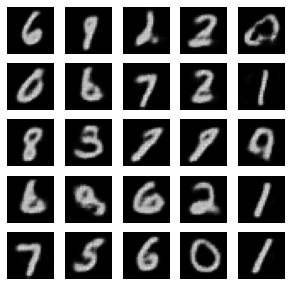

In [ ]:
generate_imgs(vae_mnist,25,z_dim)

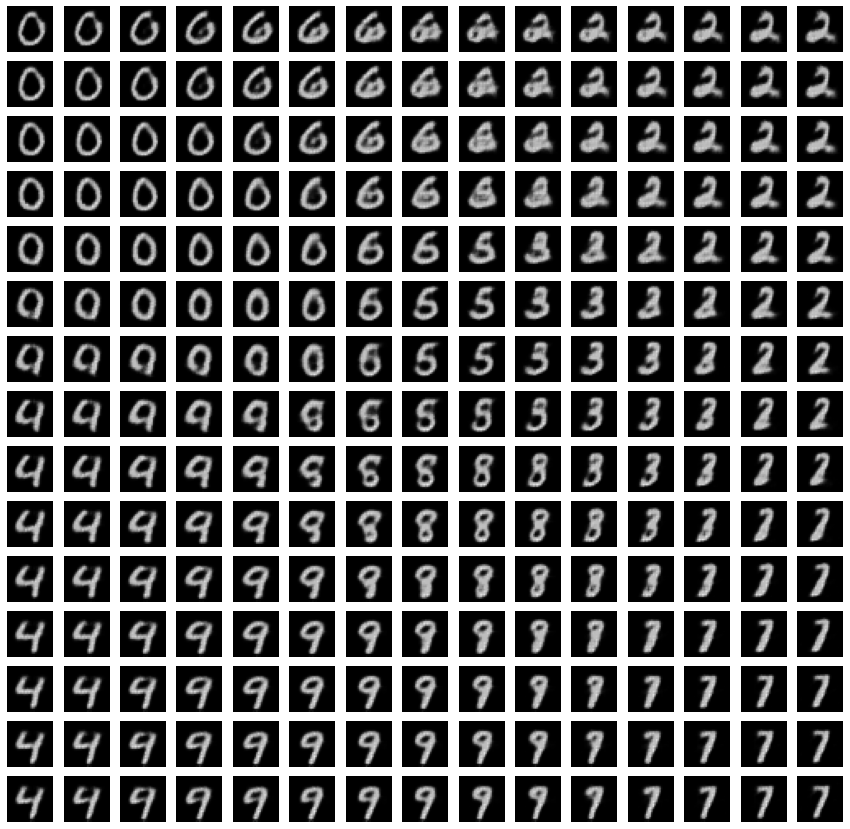

In [ ]:
generate_plan_imgs(vae_mnist,15,15,z_dim,[-2,2],[-2,2],V)


# **VAE for fashion-MNIST**

## **Architecture**

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, nb_features):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.bn    = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)

        self.linear1 = nn.Linear(3*3*32, 128)

        self.linear_mean = nn.Linear(128, nb_features)
        self.linear_std  = nn.Linear(128, nb_features)

        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))

        mean = self.linear_mean(x)
        std  = torch.exp(self.linear_std(x))

        z = mean + std * torch.distributions.Normal(0,1).sample(mean.shape).to(device)
        self.kl = (0.5 * (mean**2 + std**2 - torch.log(0.00000001+std**2) -1 )).mean()

        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nb_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(nb_features,128)
        self.linear2 = nn.Linear(128,3*3*32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.bn1      = nn.BatchNorm2d(16)
        self.bn2      = nn.BatchNorm2d(8)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = nn.Sigmoid()(self.deconv3(x))
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, nb_features):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(nb_features)
        self.decoder = Decoder(nb_features)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## **Train**

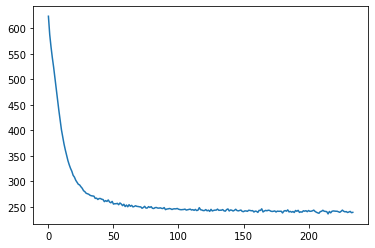

In [ ]:
train_ds, test_ds = load_fashion_mnist()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)
z_dim = 4

vae_fashion   = VariationalAutoencoder(z_dim).to(device)
optimizer  = optim.Adam(vae_fashion.parameters(), lr=0.001, weight_decay=0.00001)

fit_vae(vae_fashion, optimizer, train_dl, epochs=10, window_size=10)

## **Latent Space**

In [ ]:
z_train = torch.empty([0,z_dim]).to(device)
label_train = torch.empty([0]).to(device)
for (batch_x, batch_y) in train_dl:
  batch_x, batch_y = batch_x.to(device), batch_y.to(device)
  out  = vae_fashion.encoder(batch_x)
  z_train = torch.cat([z_train,out])
  label_train = torch.cat([label_train,batch_y])

explained variance: tensor(0.6661, device='cuda:0', grad_fn=<DivBackward0>)


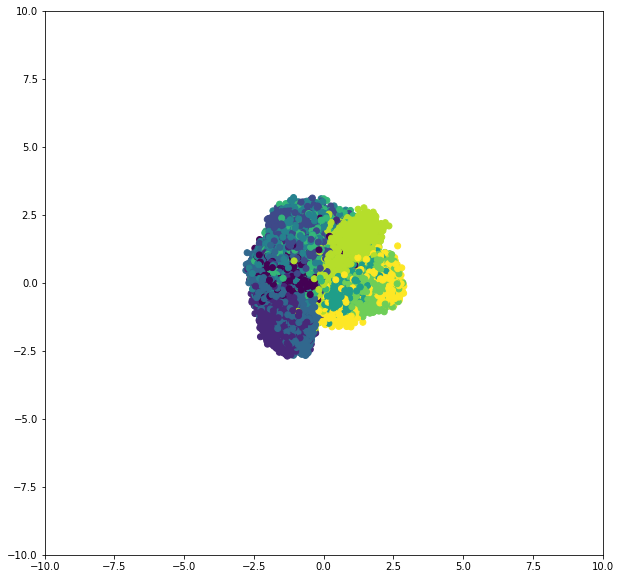

In [ ]:
U, S, V = torch.pca_lowrank(z_train)
U = U.to(device)
S = S.to(device)
V = V.to(device)
z_train_2dim = torch.matmul(z_train,V[:,:2]).to(device)

print('explained variance: '+str(torch.sum(S[:2]**2/(60000))/torch.sum(S**2/(60000))))

plt.figure(figsize=(10,10))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(z_train_2dim[:,0].cpu().detach().numpy(),z_train_2dim[:,1].cpu().detach().numpy(),c=label_train.cpu())

## **Reconstruction and Generation of the images**

In [ ]:
reconstruct_imgs(vae_fashion,test_ds,25)

In [ ]:
generate_imgs(vae_fashion,25,z_dim)

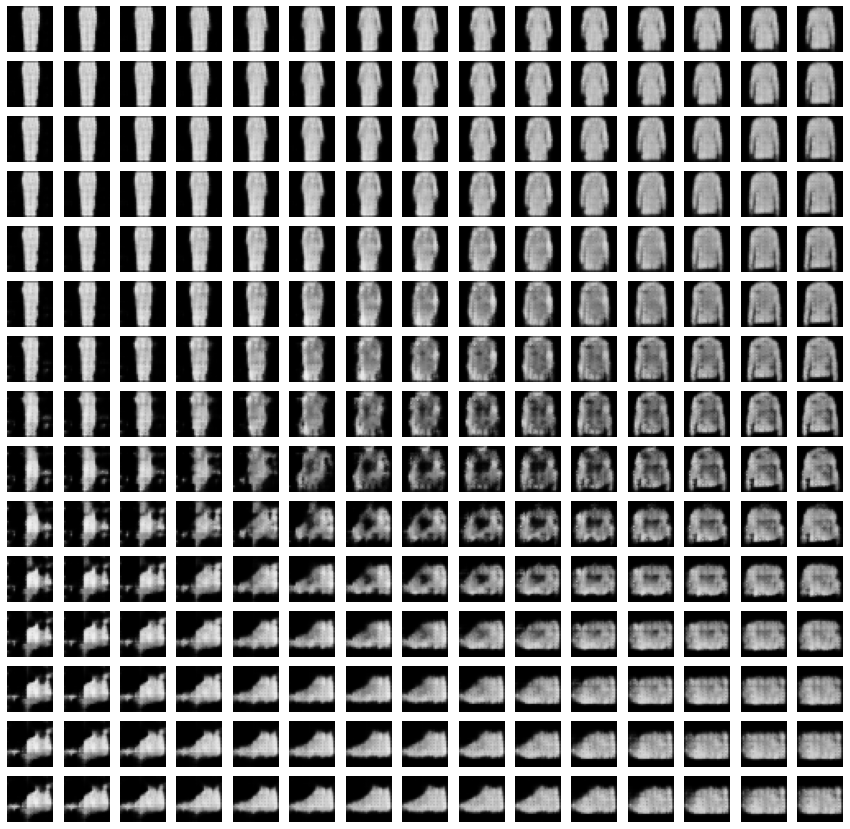

In [ ]:
generate_plan_imgs(vae_fashion,15,15,z_dim,[-2,2],[-2,2],V)

# **VAE for CIFAR-10**

### **Architecture**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, nb_features):  
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv1bis = nn.Conv2d(32, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv2bis = nn.Conv2d(32, 32, 3, padding="same")
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3bis = nn.Conv2d(64, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4bis = nn.Conv2d(128, 128, 3, padding="same")

        self.linear_mean = nn.Linear(128*2*2, nb_features)
        self.linear_std  = nn.Linear(128*2*2, nb_features)

        self.kl = 0

        self.bn1    = nn.BatchNorm2d(32)
        self.bn2    = nn.BatchNorm2d(32)
        self.bn3    = nn.BatchNorm2d(64)


    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn1(self.conv1bis(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn2(self.conv2bis(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3(self.conv3bis(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv4bis(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.linear_mean(x)
        sigma  = torch.exp(self.linear_std(x))

        z = mu + sigma * torch.distributions.Normal(0,1).sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nb_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(nb_features,128*2*2)

        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)

        self.conv4    = nn.Conv2d(32, 32, 3, padding="same")
        self.conv3    = nn.Conv2d(32, 32, 3, padding="same")
        self.conv2    = nn.Conv2d(64, 64, 3, padding="same")
        self.conv1    = nn.Conv2d(128, 128, 3, padding="same")


        self.bn1      = nn.BatchNorm2d(32)
        self.bn2      = nn.BatchNorm2d(32)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = nn.Unflatten(dim=1, unflattened_size=(128, 2, 2))(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.bn1(self.deconv2(x)))
        x = F.relu(self.bn1(self.conv3(x)))
        x = F.relu(self.bn2(self.deconv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = nn.Sigmoid()(self.deconv4(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, nb_features):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(nb_features)
        self.decoder = Decoder(nb_features)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### **Training & Evaluation**

In [ ]:
train_ds, test_ds = load_cifar10()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

vae_cifar  = Autoencoder(256).to(device)
optimizer = optim.Adam(vae_cifar.parameters(),lr=0.00001)

fit_vae(vae_cifar, optimizer, train_dl, epochs=50, window_size=10)

--- EPOCH 4/50
2084.1806982421876 531776.375 28871.75
2086.6788818359373 530442.0 28796.546875
2083.6996826171876 529503.4375 28721.75
2086.0940673828127 531635.4375 28402.64453125
2082.8462646484377 530093.625 28719.099609375
2084.2483642578127 531011.75 28781.07421875
2078.3292724609373 527304.25 28561.48046875


In [ ]:
reconstruct_imgs(vae_cifar,test_ds,25)

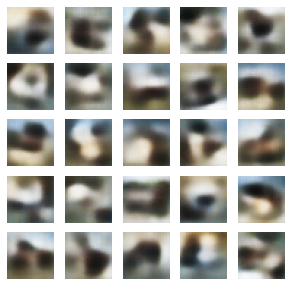

In [ ]:
generate_imgs(vae_cifar,25,256)

# **CVAE for MNIST**

In [10]:
def load_mnist_cvae():
  transforms        = torchvision.transforms.ToTensor() # Convert raw images to tensors
  to_one_hot = torchvision.transforms.Compose([
      lambda x: torch.tensor([x]),
      lambda x: nn.functional.one_hot(x, 10).squeeze()]) # label to one-hot
  mnist_trainset    = datasets.MNIST(root='./data', train=True,  download=True, transform=transforms, target_transform=to_one_hot)
  mnist_testset     = datasets.MNIST(root='./data', train=False, download=True, transform=transforms, target_transform=to_one_hot)
  
  return mnist_trainset, mnist_testset

## **Architecture**

In [11]:
class ConditionalEncoder(nn.Module):
    def __init__(self, nb_features):
        super(ConditionalEncoder, self).__init__()
 
        self.linear1 = nn.Linear(28 * 28 + 10, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 128)
 
        self.linear_mean = nn.Linear(128, nb_features)
        self.linear_std = nn.Linear(128, nb_features)
 
        self.kl = 0
 
    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((x, y), dim=1)
        x = x.to(device)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
 
        mean = self.linear_mean(x)
        std = torch.exp(self.linear_std(x))
 
        z = mean + std * torch.distributions.Normal(0, 1).sample(mean.shape).to(device)
        self.kl = (0.5 * (mean ** 2 + std ** 2 - torch.log(0.00000001 + std ** 2) - 1)).mean()
 
        return z

In [12]:
class ConditionalDecoder(nn.Module):
    def __init__(self, nb_features):
        super(ConditionalDecoder, self).__init__()
        self.linear1 = nn.Linear(nb_features + 10, 128)
        self.linear2 = nn.Linear(128, 3 * 3 * 32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(8)
 
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))(x)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = nn.Sigmoid()(self.deconv3(x))
        return x

In [13]:
class ConditionalVAE(nn.Module):
    def __init__(self, nb_features):
        super(ConditionalVAE, self).__init__()
        self.encoder = ConditionalEncoder(nb_features)
        self.decoder = ConditionalDecoder(nb_features)
 
    def forward(self, x, y):
        x = x.to(device)
        z = self.encoder(x, y)
        return self.decoder(z, y)

## **Training & Evaluation**

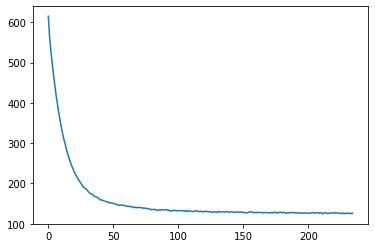

In [15]:
train_ds, test_ds = load_mnist_cvae()
train_dl, test_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True), \
                    torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)


nb_features = 2
 
cvae_mnist = ConditionalVAE(nb_features).to(device)
optimizer = optim.Adam(cvae_mnist.parameters(), lr=0.001, weight_decay=0.00001)

fit_vae(cvae_mnist, optimizer, train_dl, epochs=10, window_size=10, conditional=True)

In [16]:
reconstruct_imgs(cvae_mnist, test_ds, 25, True)

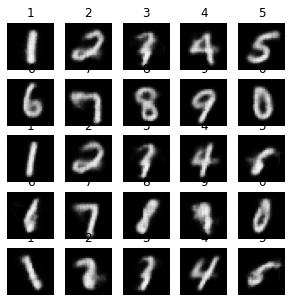

In [17]:
generate_imgs(cvae_mnist, 25, nb_features, True)